In [1]:
import pandas as pd
import numpy as np
import pgmpy
from pgmpy.estimators import HillClimbSearch, TreeSearch, BicScore, K2Score, BDeuScore
from pgmpy.estimators import BayesianEstimator
from pgmpy.models import BayesianModel
from pgmpy.inference import VariableElimination, BeliefPropagation
from graphviz import Digraph
from sklearn.preprocessing import KBinsDiscretizer
import matplotlib.pyplot as plt
import logging
logger = logging.getLogger("pgmpy")
logger.propagate = False

In [2]:
def discretize(df_data, num_bins, binning_strategy):
    discretizer = KBinsDiscretizer(n_bins = num_bins, encode = 'ordinal', strategy = binning_strategy)
    discretizer_fitted = discretizer.fit(df_data)
    data_discretized = discretizer.transform(df_data)

    for i in range(df_data.shape[1]):
        df_data.iloc[:, i] = data_discretized[:, i]
    #df_data.to_csv('features_discretized.csv', index = False)
    return df_data

In [3]:
# Load a dummy data file and discretizing the data
num_bins = 3
binning_strategy = 'quantile'
df_data = pd.read_csv('communitytesting.csv').iloc[:, 1:]
df_data.fillna(df_data.mean(), inplace=True)
df_discretized_data = discretize(df_data, num_bins, binning_strategy)

### Building the network and estimating CPD

In [4]:
structure_estimator = HillClimbSearch(df_discretized_data, scoring_method = K2Score(df_discretized_data))
model_structure = structure_estimator.estimate()
edges = model_structure.edges()
roots = model_structure.get_roots()
leaves = model_structure.get_leaves()

  0%|          | 9/1000000 [00:00<15:22:58, 18.06it/s]


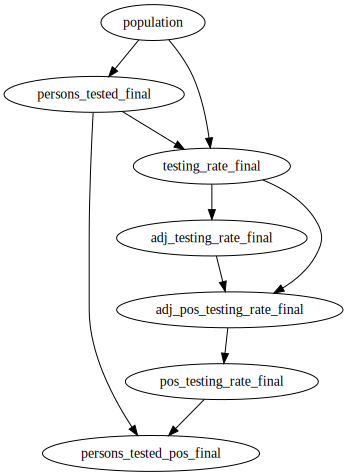

In [5]:
G = Digraph(format = 'png')
G.edges(edges)
G

In [6]:
model_structure_bayes = BayesianModel(ebunch = edges)
model_structure_bayes.fit(data = df_discretized_data, estimator = BayesianEstimator, prior_type='K2')


In [7]:
model_structure_bayes.get_cpds()

[<TabularCPD representing P(persons_tested_final:3 | population:3) at 0x122a00240>,
 <TabularCPD representing P(persons_tested_pos_final:3 | persons_tested_final:3, pos_testing_rate_final:3) at 0x10457f5f8>,
 <TabularCPD representing P(testing_rate_final:3 | persons_tested_final:3, population:3) at 0x122ac0cc0>,
 <TabularCPD representing P(adj_testing_rate_final:3 | testing_rate_final:3) at 0x10457f240>,
 <TabularCPD representing P(adj_pos_testing_rate_final:3 | adj_testing_rate_final:3, testing_rate_final:3) at 0x122ac02e8>,
 <TabularCPD representing P(pos_testing_rate_final:3 | adj_pos_testing_rate_final:3) at 0x122b07ef0>,
 <TabularCPD representing P(population:3) at 0x122b14080>]

In [8]:
print(model_structure_bayes.get_cpds('population'))

+-----------------+----------+
| population(0.0) | 0.333333 |
+-----------------+----------+
| population(1.0) | 0.333333 |
+-----------------+----------+
| population(2.0) | 0.333333 |
+-----------------+----------+


In [9]:
print(model_structure_bayes.get_cpds('persons_tested_pos_final'))

+-------------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+
| persons_tested_final          | persons_tested_final(0.0)   | persons_tested_final(0.0)   | persons_tested_final(0.0)   | persons_tested_final(1.0)   | persons_tested_final(1.0)   | persons_tested_final(1.0)   | persons_tested_final(2.0)   | persons_tested_final(2.0)   | persons_tested_final(2.0)   |
+-------------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+-----------------------------+
| pos_testing_rate_final        | pos_testing_rate_final(0.0) | pos_testing_rate_final(1

In [10]:
model_structure_bayes.local_independencies('testing_rate_final')

### Experimenting with some inference tasks

In [11]:
model_variable_eliminated = BeliefPropagation(model_structure_bayes)
q1 = model_variable_eliminated.query(variables = ['testing_rate_final'], evidence = {'adj_testing_rate_final': 0.0})
print(q1)

Eliminating: adj_pos_testing_rate_final: 100%|██████████| 3/3 [00:00<00:00, 336.88it/s]

+-------------------------+---------------------------+
| testing_rate_final      |   phi(testing_rate_final) |
+=========================+===========================+
| testing_rate_final(0.0) |                    0.9383 |
+-------------------------+---------------------------+
| testing_rate_final(1.0) |                    0.0355 |
+-------------------------+---------------------------+
| testing_rate_final(2.0) |                    0.0262 |
+-------------------------+---------------------------+


In [12]:
q2 = model_variable_eliminated.query(variables = ['testing_rate_final'], evidence = {'adj_testing_rate_final': 2.0})
print(q2)

Eliminating: adj_pos_testing_rate_final: 100%|██████████| 3/3 [00:00<00:00, 327.19it/s]

+-------------------------+---------------------------+
| testing_rate_final      |   phi(testing_rate_final) |
+=========================+===========================+
| testing_rate_final(0.0) |                    0.0264 |
+-------------------------+---------------------------+
| testing_rate_final(1.0) |                    0.0981 |
+-------------------------+---------------------------+
| testing_rate_final(2.0) |                    0.8756 |
+-------------------------+---------------------------+


In [13]:
q3 = model_variable_eliminated.query(variables = ['testing_rate_final'], evidence = {'adj_testing_rate_final': 0.0, 'adj_pos_testing_rate_final': 2.0})
print(q3)

Eliminating: population: 100%|██████████| 3/3 [00:00<00:00, 395.98it/s]   

+-------------------------+---------------------------+
| testing_rate_final      |   phi(testing_rate_final) |
+=========================+===========================+
| testing_rate_final(0.0) |                    0.9204 |
+-------------------------+---------------------------+
| testing_rate_final(1.0) |                    0.0422 |
+-------------------------+---------------------------+
| testing_rate_final(2.0) |                    0.0373 |
+-------------------------+---------------------------+


In [14]:
# Try to compare variable elimination and belief propagation.
# Here this produced the same results as belief propagation.

model_variable_eliminated = VariableElimination(model_structure_bayes)
q1 = model_variable_eliminated.query(variables = ['testing_rate_final'], evidence = {'adj_testing_rate_final': 0.0})
print(q1)

Eliminating: adj_pos_testing_rate_final: 100%|██████████| 5/5 [00:00<00:00, 74.62it/s]

+-------------------------+---------------------------+
| testing_rate_final      |   phi(testing_rate_final) |
+=========================+===========================+
| testing_rate_final(0.0) |                    0.9383 |
+-------------------------+---------------------------+
| testing_rate_final(1.0) |                    0.0355 |
+-------------------------+---------------------------+
| testing_rate_final(2.0) |                    0.0262 |
+-------------------------+---------------------------+
